In [4]:
import gmaps
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from citipy import citipy
import matplotlib.pyplot as plt
from scipy import stats
from config import api_key


In [5]:
abnb_data = pd.read_csv("Resources/airbnb_data.csv")

C:\Users\ohkyu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
abnb2 = abnb_data.drop(['neighbourhood_group', 'id', 'host_id', 'host_name', 'calculated_host_listings_count', 'last_review'], axis=1)
abnb2_df = abnb2.drop(abnb2[abnb2['room_type'] == 'Private room'].index)
abnb2_df['city'] = abnb2_df['city'].replace({'Broward County':'Fort Lauderdale','Clark County':'Las Vegas','New York City':'New York','San Clara Country':'San Jose','San Mateo County':'San Mateo','Santa Cruz County':'Santa Cruz','Twin Cities MSA':'Twin Cities','Washington D.C.':'Washington'})
abnb_df = abnb2_df.drop(abnb2_df[(abnb2_df['city'] == 'Hawaii') | (abnb2_df['city'] == 'Rhode Island') | (abnb2_df['city'] == 'Twin Cities')].index)

abnb_df = abnb_df[['city', 'name', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']]
abnb_df.rename(columns={'city': 'City', 'name': 'Property Name', 'neighbourhood': 'Neighborhood', 'latitude': 'Latitude', 'longitude': 'Longitude', 'room_type': 'Room Type', 'price': 'Price', 'minimum_nights': 'Minimum Nights', 'number_of_reviews': 'Number of Reviews', 'reviews_per_month': 'Reviews per Month', 'availability_365': 'Availability (days per year)'}, inplace=True)

abnb_df


,City,Property Name,Neighborhood,Latitude,Longitude,Room Type,Price,Minimum Nights,Number of Reviews,Reviews per Month,Availability (days per year)
1,Asheville,French Chic Loft,28801,35.597790,-82.555400,Entire home/apt,470,1,114,1.03,288
2,Asheville,Walk to stores/parks/downtown. Fenced yard/Pet...,28801,35.606700,-82.555630,Entire home/apt,75,30,89,0.81,298
3,Asheville,Cottage! BonPaul + Sharky's Hostel,28806,35.578640,-82.595780,Entire home/apt,90,1,267,2.39,0
5,Asheville,Terrace Cottage,28804,35.618560,-82.552760,Entire home/apt,134,7,54,0.49,294
8,Asheville,"Private, peaceful, and free goat therapy",28805,35.619290,-82.481140,Entire home/apt,71,28,537,5.01,207
...,...,...,...,...,...,...,...,...,...,...,...
226025,Washington,"DC Hidden In Plain ""Site""","Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104,1,0,NaN,99
226026,Washington,DC 3 BR w/ screen porch 3 blck to metro w/ par...,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151,2,0,NaN,300
226027,Washington,Charming Penthouse Apt w/ Rooftop Terrace in L...,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240,2,0,NaN,173
226028,Washington,Adams Morgan/Nat'l Zoo 1 BR Apt #32,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60,21,0,NaN,362


In [7]:
Cities = []
for city in abnb_df['City']:
    if city not in Cities:
        Cities.append(city)

In [8]:
cities = [city.lower() for city in Cities]

In [9]:
states = ['NC', 'TX', 'MA', 'FL', 'MA', 'IL', 'NV', 'OH', 'CO', 'NJ', 'CA', 'TN', 'LA', 'NY', 'CA', 'CA', 'OR', 'OR', 'CA', 'CA', 'CA', 'CA', 'CA', 'WA', 'DC']

In [10]:
loop_df = pd.DataFrame({
    'city': cities,
    'City': Cities,
    'State': states
})

loop_df['Population'] = ''

loop_df

,city,City,State,Population
0,asheville,Asheville,NC,
1,austin,Austin,TX,
2,boston,Boston,MA,
3,fort lauderdale,Fort Lauderdale,FL,
4,cambridge,Cambridge,MA,
5,chicago,Chicago,IL,
6,las vegas,Las Vegas,NV,
7,columbus,Columbus,OH,
8,denver,Denver,CO,
9,jersey city,Jersey City,NJ,


In [11]:
for index, row in loop_df.iterrows():
    city = row["city"]
    City = row["City"]
    state = row["State"]
    url = f'http://public.opendatasoft.com/api/records/1.0/search/?dataset=cities-and-towns-of-the-united-states%40public&q={city}&facet=name&facet=state&refine.name={City}&refine.state={state}'
    response = requests.get(url).json()
    print(f"Searching population record for {city}")
    
    try:
        loop_df.loc[index, "Population"] = response['records'][0]['fields']['pop_2010']
    
        print(f"{city}'s population: {response['records'][0]['fields']['pop_2010']}")
    
        print('________________________________________________')
    
    except (KeyError, IndexError):
        print(f"Population for {city} not found... Continue scanning.")
        
        print('________________________________________________')

Searching population record for asheville
asheville's population: 83393
________________________________________________
Searching population record for austin
austin's population: 790390
________________________________________________
Searching population record for boston
boston's population: 617594
________________________________________________
Searching population record for fort lauderdale
fort lauderdale's population: 165521
________________________________________________
Searching population record for cambridge
cambridge's population: 105162
________________________________________________
Searching population record for chicago
chicago's population: 2695598
________________________________________________
Searching population record for las vegas
las vegas's population: 583756
________________________________________________
Searching population record for columbus
columbus's population: 787033
________________________________________________
Searching population record fo

In [12]:
loop_df

,city,City,State,Population
0,asheville,Asheville,NC,83393
1,austin,Austin,TX,790390
2,boston,Boston,MA,617594
3,fort lauderdale,Fort Lauderdale,FL,165521
4,cambridge,Cambridge,MA,105162
5,chicago,Chicago,IL,2695598
6,las vegas,Las Vegas,NV,583756
7,columbus,Columbus,OH,787033
8,denver,Denver,CO,600158
9,jersey city,Jersey City,NJ,247597


In [13]:
graphs_draft_df = abnb_df.groupby('City').mean().reset_index()
graphs_draft_df['Population'] = loop_df['Population']
graphs_draft_df['State'] = loop_df['State']
graphs_df = graphs_draft_df[['City', 'State', 'Population', 'Latitude', 'Longitude', 'Price', 'Minimum Nights', 'Number of Reviews', 'Reviews per Month', 'Availability (days per year)']]
graphs_df['Population']=pd.to_numeric(graphs_df['Population'], errors='coerce')

In [14]:
# 'sort by population
sort_Population_graphs_df = graphs_df.sort_values(by='Population', ascending=False)
sort_Population_graphs_df.head()

,City,State,Population,Latitude,Longitude,Price,Minimum Nights,Number of Reviews,Reviews per Month,Availability (days per year)
13,New York,NY,8175133,40.728863,-73.958841,198.507506,10.492615,22.661877,0.875777,124.242193
10,Los Angeles,CA,3792621,34.042671,-118.337056,281.473336,19.850302,36.910889,1.591118,178.280363
5,Columbus,IL,2695598,39.984240,-82.996481,395.042333,8.599247,47.689558,2.868683,160.244591
19,San Francisco,CA,1307402,37.768774,-122.429203,318.417380,20.415624,39.447882,1.217099,168.416283
18,San Diego,CA,945942,32.766330,-117.190983,381.389202,6.052923,40.767330,1.768815,152.632414


In [15]:
# Set x axis and tick locations
x_axis = np.arange(len(sort_Population_graphs_df))
tick_locations = [value+0.4 for value in x_axis]

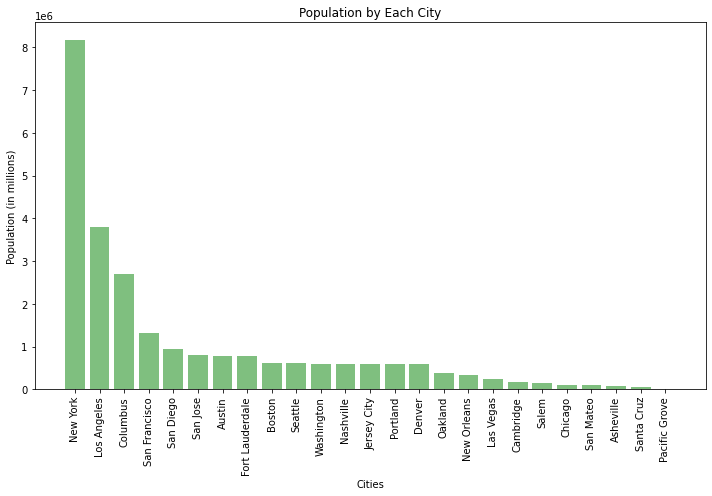

In [16]:
#Bar Graph Population VS City
plt.figure(figsize=(10,7))
plt.bar(x_axis, sort_Population_graphs_df["Population"], color='green', alpha=0.5, align="edge")
plt.xticks(tick_locations, sort_Population_graphs_df["City"], rotation="vertical")

plt.title('Population by Each City')
plt.xlabel("Cities")
plt.ylabel("Population (in millions)")

# Save our graph and show the grap
plt.tight_layout()
plt.savefig('Resources/pop_by_city.png')
plt.show()

In [17]:
# 'sort by Availability (days per year)
sort_availablity_graphs_df = graphs_df.sort_values(by='Availability (days per year)', ascending=False)
sort_availablity_graphs_df.head()

,City,State,Population,Latitude,Longitude,Price,Minimum Nights,Number of Reviews,Reviews per Month,Availability (days per year)
7,Fort Lauderdale,OH,787033,26.098144,-80.138814,264.226556,7.100666,21.238818,1.339888,202.122153
11,Nashville,TN,601222,36.161734,-86.772334,230.346161,4.708709,54.197938,2.261393,190.496041
8,Jersey City,CO,600158,40.726335,-74.052016,167.781026,10.259547,29.986277,1.543465,186.286993
2,Boston,MA,617594,42.343169,-71.080080,209.841602,34.919891,37.570778,1.625987,184.854802
9,Las Vegas,NJ,247597,36.116909,-115.145809,243.013242,7.317966,32.129312,1.863386,184.842406


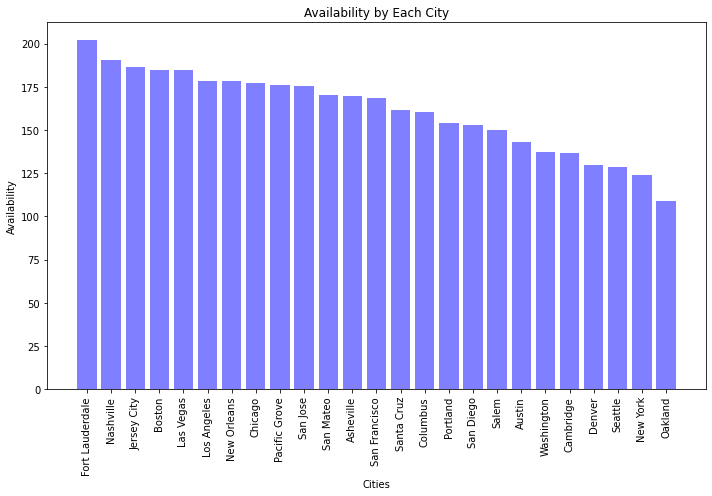

In [18]:
# Set x axis and tick locations
x_axis = np.arange(len(sort_availablity_graphs_df))
tick_locations = [value+0.4 for value in x_axis]

#Bar Graph Availability VS City
plt.figure(figsize=(10,7))
plt.bar(x_axis, sort_availablity_graphs_df["Availability (days per year)"], color='blue', alpha=0.5, align="edge")
plt.xticks(tick_locations, sort_availablity_graphs_df["City"], rotation="vertical")

plt.title('Availability by Each City')
plt.xlabel("Cities")
plt.ylabel("Availability")

# Save our graph and show the grap
plt.tight_layout()
plt.savefig('Resources/availibity_by_city.png')
plt.show()

In [19]:
# 'sort by Price
sort_Price_graphs_df = graphs_df.sort_values(by='Price', ascending=False)
sort_Price_graphs_df.head()

,City,State,Population,Latitude,Longitude,Price,Minimum Nights,Number of Reviews,Reviews per Month,Availability (days per year)
5,Columbus,IL,2695598,39.984240,-82.996481,395.042333,8.599247,47.689558,2.868683,160.244591
18,San Diego,CA,945942,32.766330,-117.190983,381.389202,6.052923,40.767330,1.768815,152.632414
19,San Francisco,CA,1307402,37.768774,-122.429203,318.417380,20.415624,39.447882,1.217099,168.416283
1,Austin,TX,790390,30.282802,-97.755954,311.782487,9.479961,33.144644,1.439457,142.824630
22,Santa Cruz,CA,59946,36.985513,-121.975032,292.747791,4.204819,62.538153,1.855995,161.805622


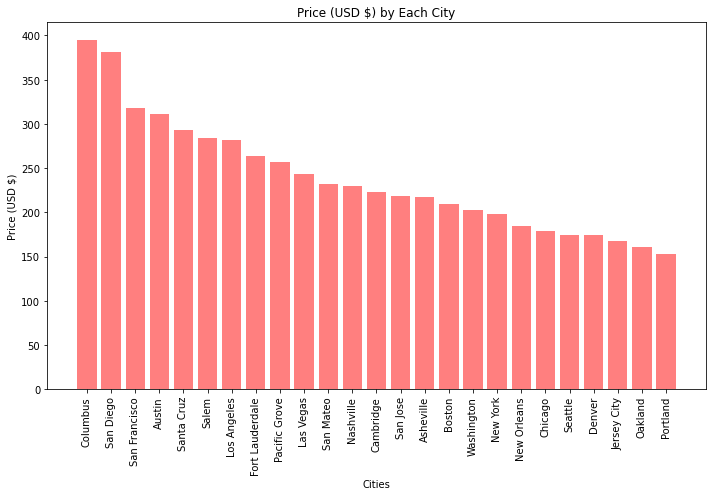

In [20]:
# Set x axis and tick locations
x_axis = np.arange(len(sort_availablity_graphs_df))
tick_locations = [value+0.4 for value in x_axis]

#Bar Graph Price VS City
plt.figure(figsize=(10,7))
plt.bar(x_axis, sort_Price_graphs_df["Price"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, sort_Price_graphs_df["City"], rotation="vertical")

plt.title('Price (USD $) by Each City')
plt.xlabel("Cities")
plt.ylabel("Price (USD $)")

# Save our graph and show the grap
plt.tight_layout()
plt.savefig('Resources/Price_by_city.png')
plt.show()

In [23]:
# 'sort by Number of reviews
sort_review_graphs_df = graphs_df.sort_values(by='Reviews per Month', ascending=False)
sort_review_graphs_df.head()

,City,State,Population,Latitude,Longitude,Price,Minimum Nights,Number of Reviews,Reviews per Month,Availability (days per year)
0,Asheville,NC,83393,35.578463,-82.557080,217.851462,5.445029,76.460819,2.915155,169.638596
5,Columbus,IL,2695598,39.984240,-82.996481,395.042333,8.599247,47.689558,2.868683,160.244591
16,Portland,OR,583776,45.528396,-122.653810,152.780577,9.149317,82.048558,2.659966,154.163885
11,Nashville,TN,601222,36.161734,-86.772334,230.346161,4.708709,54.197938,2.261393,190.496041
15,Pacific Grove,CA,15041,36.621462,-121.921354,256.744828,17.862069,76.593103,2.186271,176.041379


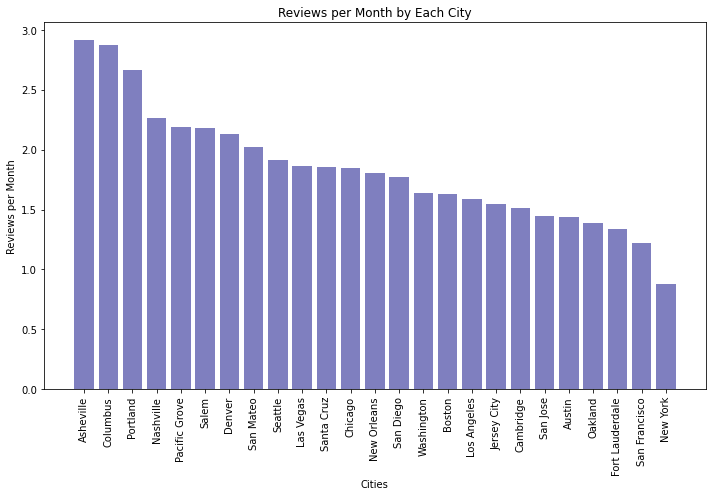

In [43]:
# Set x axis and tick locations
x_axis = np.arange(len(sort_review_graphs_df))
tick_locations = [value+0.4 for value in x_axis]

#Bar Graph Reviews per Month VS City
plt.figure(figsize=(10,7))
plt.bar(x_axis, sort_review_graphs_df["Reviews per Month"], color='Navy', alpha=0.5, align="edge")
plt.xticks(tick_locations, sort_review_graphs_df["City"], rotation="vertical")

plt.title('Reviews per Month by Each City')
plt.xlabel("Cities")
plt.ylabel("Reviews per Month")

# Save our graph and show the grap
plt.tight_layout()
plt.savefig('Resources/Review_by_city.png')
plt.show()

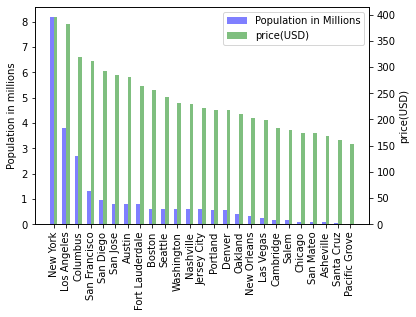

In [61]:
#Bar Graph Population VS Price_of_City

x = np.arange(len(sort_Population_graphs_df))
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective City.
plt.xticks(x + w /2, sort_Population_graphs_df['City'], rotation='vertical')
population =ax1.bar(x, sort_Population_graphs_df['Population']/ 10 ** 6, width=w, color='b', align='center',alpha=0.5)
plt.ylabel('Population in millions')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()

price =ax2.bar(x + w, sort_Price_graphs_df['Price'] , width=w,color='g',align='center',alpha=0.5)
#Set the Y axis label as Price.
plt.ylabel('price(USD)')
#To set the legend on the plot we have used plt.legend()
plt.legend([population, price],['Population in Millions', 'price(USD)'])
#To show the plot finally we have used plt.show().
plt.savefig('Resources/Population VS Price_City.png')
plt.show()

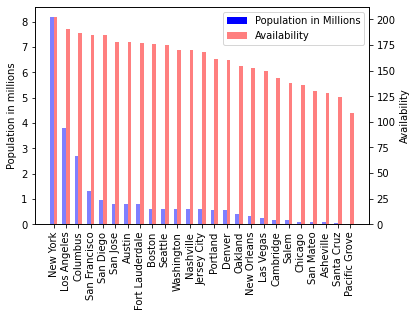

In [54]:
#Bar Graph Population VS Availibilty_of_City
x = np.arange(len(sort_Population_graphs_df))
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective City.
plt.xticks(x + w /2, sort_Population_graphs_df['City'], rotation='vertical')
population =ax1.bar(x, sort_Population_graphs_df['Population']/ 10 ** 6, width=w, color='b', align='center',alpha=0.5)
plt.ylabel('Population in millions')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()

availability =ax2.bar(x + w, sort_availablity_graphs_df["Availability (days per year)"] , width=w,color='r',align='center',alpha=0.5)
#Set the Y axis label as Price.
plt.ylabel('Availability')
#To set the legend on the plot we have used plt.legend()
plt.legend([pop, availability],['Population in Millions', 'Availability'])
#To show the plot finally we have used plt.show().
plt.savefig('Resources/Population VS Availability (days per year).png')
plt.show()


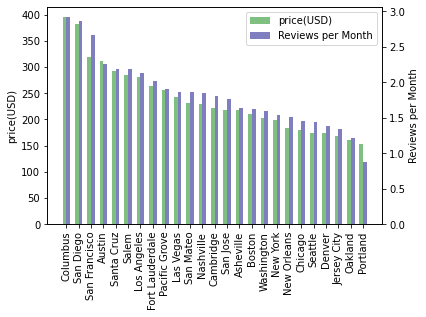

In [62]:
#Bar Graph Price VS Reviews per Month_of_City
x = np.arange(len(sort_Price_graphs_df))
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective City.
plt.xticks(x + w /2, sort_Price_graphs_df['City'], rotation='vertical')
price =ax1.bar(x, sort_Price_graphs_df['Price'], width=w, color='g', align='center',alpha=0.5)
plt.ylabel('price(USD)')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()

Review =ax2.bar(x + w, sort_review_graphs_df["Reviews per Month"] , width=w,color='navy',align='center',alpha=0.5)
#Set the Y axis label as Price.
plt.ylabel('Reviews per Month')
#To set the legend on the plot we have used plt.legend()
plt.legend([price, Review],['price(USD)', 'Reviews per Month'])
#To show the plot finally we have used plt.show().
plt.savefig('Resources/Price VS Reviews per Month.png')
plt.show()

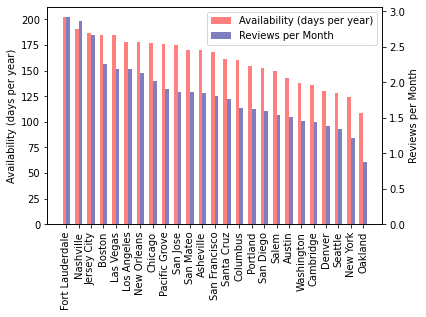

In [53]:
#Bar Graph Availibilty_of_City VS Reviews per Month_of_City
x = np.arange(len(sort_Price_graphs_df))
ax1 = plt.subplot(1,1,1)
w = 0.3
#plt.xticks(), will label the bars on x axis with the respective City.
plt.xticks(x + w /2, sort_availablity_graphs_df["City"], rotation='vertical')
population =ax1.bar(x, sort_availablity_graphs_df['Availability (days per year)'], width=w, color='r', align='center',alpha=0.5)
plt.ylabel('Availability (days per year)')
#The trick is to use two different axes that share the same x axis, we have used ax1.twinx() method.
ax2 = ax1.twinx()

Review =ax2.bar(x + w, sort_review_graphs_df["Reviews per Month"] , width=w,color='navy',align='center',alpha=0.5)
#Set the Y axis label as Price.
plt.ylabel('Reviews per Month')
#To set the legend on the plot we have used plt.legend()
plt.legend([population, Review],['Availability (days per year)', 'Reviews per Month'])
#To show the plot finally we have used plt.show().
plt.savefig('Resources/Availability (days per year) VS Reviews per Month.png')
plt.show()